**Primeiro Projeto Final**

**Disciplina Tópicos Contemporâneos**

**Discentes:**

**Valéria Cristina A. R. de Figueredo** (vcarf@cesar.school)

**Manuela de Lacerda Bezerra Carvalho** (mlbc@cesar.school)

**Objetivo do Projeto:** Fine-Tuning de uma CNN para Classificação

Um dataset de sua escolha deverá ser coletado e preparado para realizar o fine-tuning de uma CNN. O projeto será avaliado nos seguintes aspectos: Construção do Dataset, Data Augmentation, Uso de Modelos Pré-Treinados, Construção do Modelo Classificador, Congelamento de Camadas, Treinamento e Curvas de Desempenho

# **1. Baixar o dataset criado**

In [1]:
# Instalar a ferramenta gdown
!pip install gdown

# Baixar o arquivo usando gdown
!gdown "https://drive.google.com/uc?export=download&id=1-A3AumMHd48vqdhX6XNlAIvElw0xuQJP"

# Descompactar o arquivo
!unzip fruta_zip5.zip -d data/

Downloading...
From: https://drive.google.com/uc?export=download&id=1-A3AumMHd48vqdhX6XNlAIvElw0xuQJP
To: /content/fruta_zip5.zip
100% 4.49M/4.49M [00:00<00:00, 93.8MB/s]
Archive:  fruta_zip5.zip
   creating: data/train/
   creating: data/val/
   creating: data/train/abacaxi/
   creating: data/train/acerola/
   creating: data/train/banana/
   creating: data/train/maracuja/
  inflating: data/train/abacaxi/10001.jpeg  
  inflating: data/train/abacaxi/10059.jpeg  
  inflating: data/train/abacaxi/10044.jpg  
  inflating: data/train/abacaxi/10043.jpeg  
  inflating: data/train/abacaxi/10037.jpg  
  inflating: data/train/abacaxi/10014.jpeg  
  inflating: data/train/abacaxi/10045.jpg  
  inflating: data/train/abacaxi/10050.jpeg  
  inflating: data/train/abacaxi/10038.jpg  
  inflating: data/train/abacaxi/10031.jpeg  
  inflating: data/train/abacaxi/10039.jpeg  
  inflating: data/train/abacaxi/10034.jpeg  
  inflating: data/train/abacaxi/10041.jpg  
  inflating: data/train/abacaxi/10035.jpeg  

In [2]:
data_dir = "data/"

O presente dataset tem criação autoral. Imagens de quatro frutas tropicais foram extraídas do Google Imagens através da ferramenta ImageAssistant Batch Image. Foram extraídas frutas das seguintes espécies: abacaxi, acerola, banana e maracujá. Há aproximadamente 75 imagens de cada espécie para a base de treino e 20 imagens de cada espécie para a base de validação.


# **2. Bibliotecas**

In [3]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# **3. Funções para treinar, testar e avaliar modelo de aprendizado profundo**

In [5]:
def train_model(model, trainloader, valloader, criterion, optimizer, device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def show_images(images, titles=None, cols=5):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# **4. Transformações de algumas imagens**

Imagens Originais


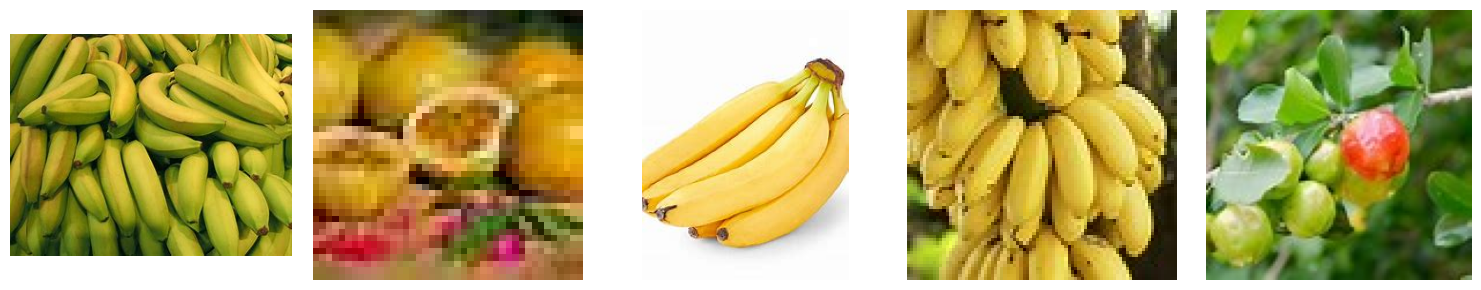

Após RandomResizedCrop


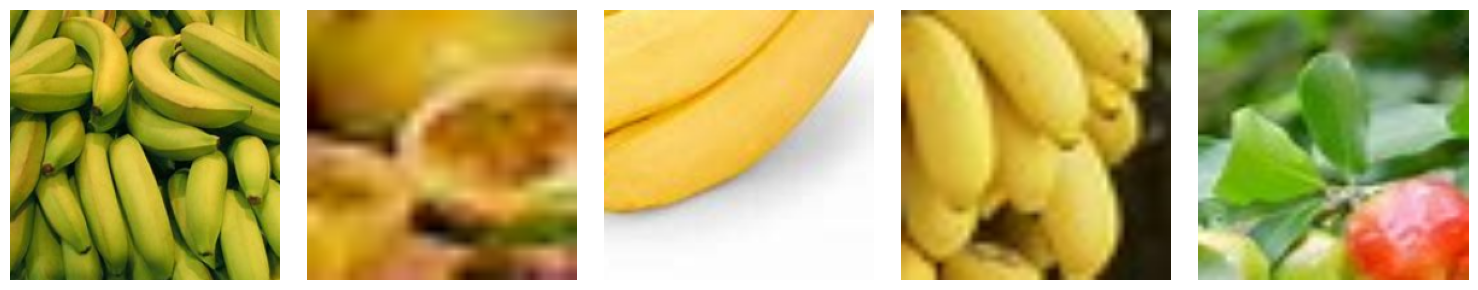

Após RandomHorizontalFlip


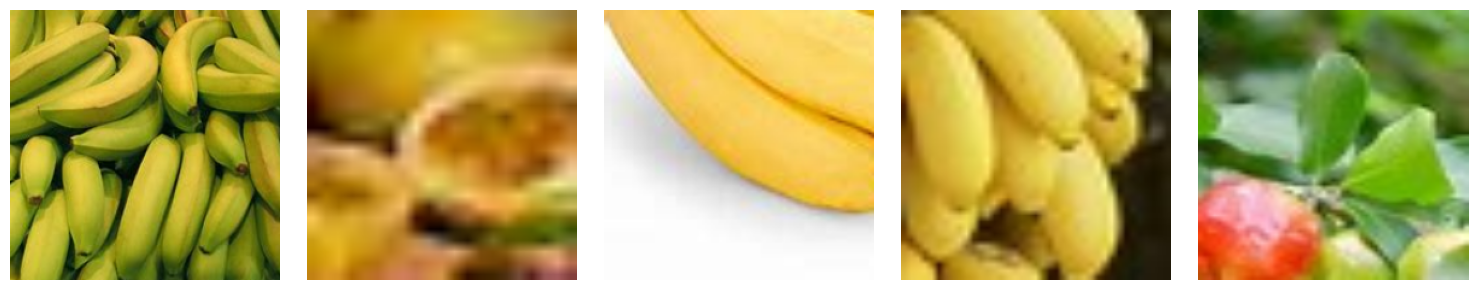

Após RandomRotation


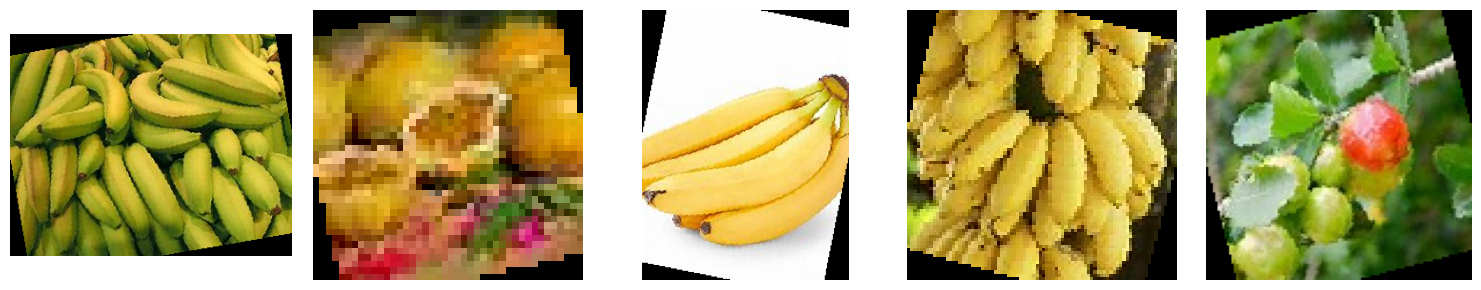

Após RandomAffine


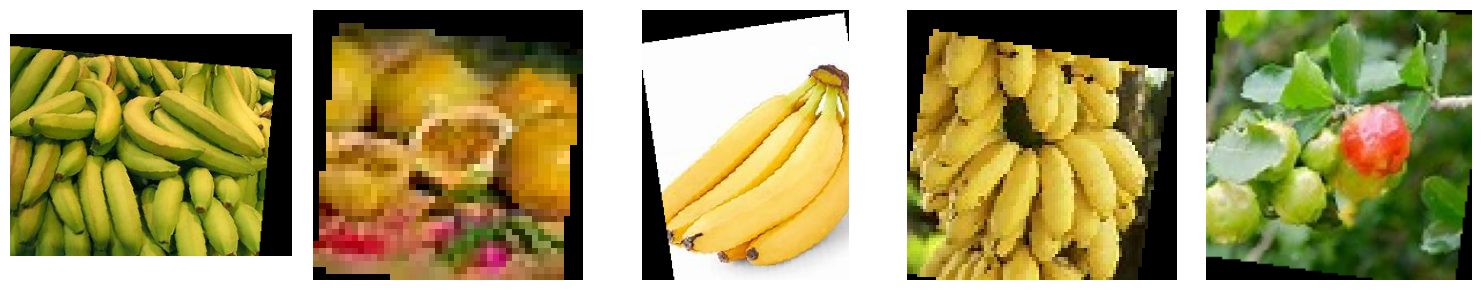

In [ ]:
example_dir = os.path.join(data_dir, 'train') #imagens da base de treino
example_set = datasets.ImageFolder(example_dir, transform=None)
example_images = [example_set[i][0] for i in random.sample(range(len(example_set)), 5)]

# Mostrando imagens originais
print("Imagens Originais")
show_images(example_images)

# Exemplo de RandomResizedCrop -corte aleatório e redimensionamento
cropped_images = [transforms.RandomResizedCrop(224)(img) for img in example_images]
print("Após RandomResizedCrop")
show_images(cropped_images)

# Exemplo de RandomHorizontalFlip - Inverte aleatoriamente as imagens horizontalmente.
flipped_images = [transforms.RandomHorizontalFlip()(img) for img in cropped_images]
print("Após RandomHorizontalFlip")
show_images(flipped_images)

# Exemplo de RandomRotation - Aplica rotações aleatórias em uma imagem
rotated_images = [transforms.RandomRotation(15)(img) for img in example_images]
print("Após RandomRotation")
show_images(rotated_images)

# Exemplo de RandomAffine - Aplica uma transformação afim aleatória em uma imagem
affined_images = [transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))(img) for img in example_images]
print("Após RandomAffine")
show_images(affined_images)

# **5. Datasets (treino e validação) com e sem aumentos (augmentations) de dados**

In [6]:
# Transformações com aumentos de dados (augmentations)
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),  # corte aleatório e redimensionamento
    transforms.RandomHorizontalFlip(),  # Inverter aleatoriamente as imagens horizontalmente
    transforms.RandomRotation(15),      # Aplica rotações aleatórias em uma imagem
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.05), # altera o brilho, contraste, saturação e matiz das imagens.
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=10), #  aplica transformações geométricas em uma imagem, como rotação, translação e cisalhamento (shear)
    transforms.RandomVerticalFlip(),  # inverte aleatoriamente uma imagem na direção vertical (de cima para baixo)
    transforms.RandomInvert(0.5),  #inverte as cores de uma imagem aleatoriamente, aplicando uma inversão de tonalidade de cor
    transforms.ToTensor(),  #apesar de ser etapa comum de pré-processamento e não aumentar a diversidade dos dados, foi deixado aqui devido a sua necessidade para aplicações e comparações
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # #apesar de ser etapa comum de pré-processamento e não aumentar a diversidade dos dados, foi deixado aqui devido a sua necessidade para aplicações e comparações
])

# Transformações sem aumentos de dados (augmentations) - técnicas de pré-processamento
transform_no_aug = transforms.Compose([
    transforms.Resize(224),  # redimensiona imagem para uma altura (ou largura) específica
    transforms.CenterCrop(224), # corta (crop) uma imagem ao redor do centro, mantendo uma região quadrada de tamanho especificado
    transforms.ToTensor(), #converte uma imagem do tipo PIL ou NumPy ndarray para um tensor PyTorch - etapa comum de pré-processamento, não aumenta a diversidade dos dados
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #usado para normalizar as imagens
])

# Aplicações das Transformações nas bases e treino e validação
train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
train_set_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True) #carrega os dados de treinamento em batches (lotes) durante o treinamento do modelo ( sem data augmentation)
train_loader_aug = DataLoader(train_set_aug, batch_size=32, shuffle=True)       #carrega os dados de treinamento em batches (lotes) durante o treinamento do modelo ( com data augmentation)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)                   #carregar os dados de validação em batches (lotes) durante o treinamento do modelo (sem data augmentation)

# **6.Rede neural convolucional simples (CNN)**

# **6.1 Primeira Tentativa - sem dropout**

In [ ]:
# primeira tentativa de função
class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=0) #camadas convolucionais são boas para extrair características hierárquicas de imagens
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 2 * 2, 128) # As camadas lineares (fc1, fc2, fc3) são responsáveis pela classificação da rede.
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0) #relu-função de ativação não linear, aplicada após as camadas convolucionais e lineares
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0) # F.max_pool2d após cada camada convolucional reduz a dimensionalidade espacial das imagens
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2, stride=2, padding=0)
        x = x.view(-1, 64 * 2 * 2) # achata a saída das camadas convolucionais para que possa ser passada para as camadas lineares.
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# Modelo
model = CNN(num_classes=4).to(device)

#Exemplo de entrada
x = torch.randn(1, 3, 224, 224).to(device)
print(model(x).shape)


torch.Size([1, 4])


**6.1.1 Aplicação do CNN -dataset sem aumento de dados**

100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Epoch 1, Train Loss: 1.382, Train Accuracy: 24.24%
Epoch 1, Val Loss: 1.350, Val Accuracy: 35.53%


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Epoch 2, Train Loss: 1.265, Train Accuracy: 40.74%
Epoch 2, Val Loss: 1.141, Val Accuracy: 43.42%


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


Epoch 3, Train Loss: 1.003, Train Accuracy: 54.21%
Epoch 3, Val Loss: 0.934, Val Accuracy: 60.53%


100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


Epoch 4, Train Loss: 0.856, Train Accuracy: 63.30%
Epoch 4, Val Loss: 1.049, Val Accuracy: 53.95%


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


Epoch 5, Train Loss: 0.807, Train Accuracy: 64.31%
Epoch 5, Val Loss: 0.757, Val Accuracy: 69.74%


100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch 6, Train Loss: 0.709, Train Accuracy: 72.39%
Epoch 6, Val Loss: 0.597, Val Accuracy: 73.68%


100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


Epoch 7, Train Loss: 0.648, Train Accuracy: 76.09%
Epoch 7, Val Loss: 0.538, Val Accuracy: 80.26%


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Epoch 8, Train Loss: 0.565, Train Accuracy: 77.78%
Epoch 8, Val Loss: 0.548, Val Accuracy: 77.63%


100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


Epoch 9, Train Loss: 0.481, Train Accuracy: 80.81%
Epoch 9, Val Loss: 0.705, Val Accuracy: 80.26%


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 10, Train Loss: 0.429, Train Accuracy: 83.50%
Epoch 10, Val Loss: 0.657, Val Accuracy: 76.32%


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


Epoch 11, Train Loss: 0.481, Train Accuracy: 83.84%
Epoch 11, Val Loss: 0.529, Val Accuracy: 78.95%


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Epoch 12, Train Loss: 0.364, Train Accuracy: 87.88%
Epoch 12, Val Loss: 0.512, Val Accuracy: 82.89%


100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


Epoch 13, Train Loss: 0.306, Train Accuracy: 89.90%
Epoch 13, Val Loss: 0.311, Val Accuracy: 86.84%


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Epoch 14, Train Loss: 0.278, Train Accuracy: 89.23%
Epoch 14, Val Loss: 0.397, Val Accuracy: 81.58%


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Epoch 15, Train Loss: 0.256, Train Accuracy: 91.25%
Epoch 15, Val Loss: 0.414, Val Accuracy: 85.53%


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


Epoch 16, Train Loss: 0.259, Train Accuracy: 90.57%
Epoch 16, Val Loss: 0.331, Val Accuracy: 85.53%


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Epoch 17, Train Loss: 0.219, Train Accuracy: 91.92%
Epoch 17, Val Loss: 0.290, Val Accuracy: 89.47%


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


Epoch 18, Train Loss: 0.188, Train Accuracy: 93.27%
Epoch 18, Val Loss: 0.237, Val Accuracy: 90.79%


100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


Epoch 19, Train Loss: 0.155, Train Accuracy: 94.95%
Epoch 19, Val Loss: 0.257, Val Accuracy: 90.79%


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Epoch 20, Train Loss: 0.103, Train Accuracy: 97.31%
Epoch 20, Val Loss: 0.399, Val Accuracy: 85.53%
Treinamento concluído


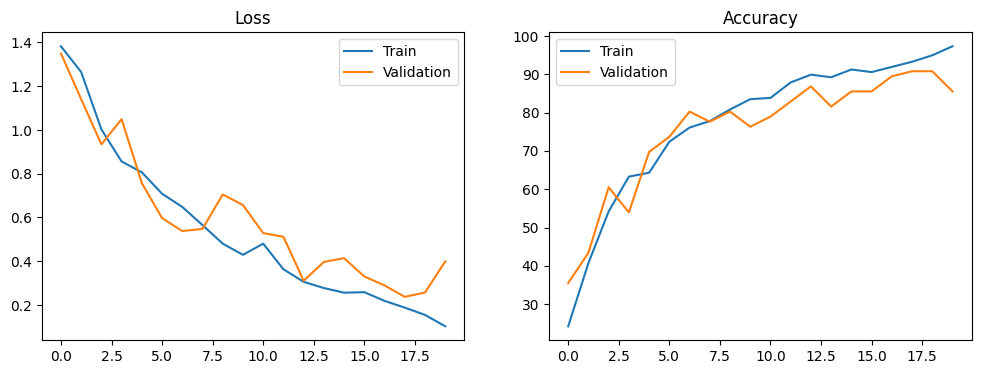

In [ ]:
model_no_aug = CNN(num_classes=4).to(device)

criterion_no_aug = nn.CrossEntropyLoss() # Função de perda para múltiplas classes
optimizer_no_aug = optim.Adam(model_no_aug.parameters(), lr=0.001)

history_no_aug = train_model(model_no_aug, train_loader_no_aug, val_loader, criterion_no_aug, optimizer_no_aug, device, num_epochs=20)

plot_history(history_no_aug)

A partir da aplicação desse modelo de CNN ao dataset sem aumento de dados, foi possível tirar as seguintes conclusões, com base nesse treinamento:

**Acurácia de Treinamento:** Começou em torno de 24% e melhorou de forma constante, atingindo 97,31% na 20ª época.

**Acurácia de Validação:** Iniciou em 35,53% e teve um progresso considerável, alcançando o pico de 90,79% nas épocas 18 e 19. No entanto, houve algumas flutuações nas últimas épocas, com a acurácia caindo para 85,53% na época 20.

**Perda de treinamento** diminuiu consistentemente, indicando que o modelo estava aprendendo efetivamente com os dados. Na 20ª época, ela caiu para 0,103.

**Perda de validação** teve algumas flutuações, especialmente entre as épocas 10 e 20. Apesar das variações na perda de validação, o desempenho do modelo (acurácia) mostrou uma melhoria geral.

Enfim, embora a acurácia de treinamento tenha se tornado muito alta, a acurácia de validação oscilou e atingiu um máximo ainda na época 18, o que pode sugerir que o modelo começou a sobreajustar (overfitting), especialmente porque a perda de validação não diminuiu consistentemente nas últimas épocas.

Para buscar melhorar os resultados, posteriormente será aplicada regularização: técnica como dropout é importante para reduzir o sobreajuste e ajudar o modelo a generalizar melhor.Também haverá o
aumento do tamanho do conjunto de dados via data augmentation.






**6.1.2 Aplicação do CNN no dataset com aumentos de dados**

100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch 1, Train Loss: 1.390, Train Accuracy: 24.58%
Epoch 1, Val Loss: 1.343, Val Accuracy: 26.32%


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Epoch 2, Train Loss: 1.361, Train Accuracy: 31.99%
Epoch 2, Val Loss: 1.230, Val Accuracy: 27.63%


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Epoch 3, Train Loss: 1.299, Train Accuracy: 39.39%
Epoch 3, Val Loss: 1.145, Val Accuracy: 53.95%


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Epoch 4, Train Loss: 1.214, Train Accuracy: 40.07%
Epoch 4, Val Loss: 1.184, Val Accuracy: 52.63%


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch 5, Train Loss: 1.134, Train Accuracy: 42.42%
Epoch 5, Val Loss: 1.156, Val Accuracy: 47.37%


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Epoch 6, Train Loss: 1.124, Train Accuracy: 40.40%
Epoch 6, Val Loss: 1.098, Val Accuracy: 44.74%


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Epoch 7, Train Loss: 1.096, Train Accuracy: 44.44%
Epoch 7, Val Loss: 1.050, Val Accuracy: 46.05%


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 8, Train Loss: 1.207, Train Accuracy: 38.38%
Epoch 8, Val Loss: 1.016, Val Accuracy: 43.42%


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Epoch 9, Train Loss: 1.120, Train Accuracy: 44.78%
Epoch 9, Val Loss: 1.015, Val Accuracy: 47.37%


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch 10, Train Loss: 1.091, Train Accuracy: 44.78%
Epoch 10, Val Loss: 0.972, Val Accuracy: 47.37%


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Epoch 11, Train Loss: 1.071, Train Accuracy: 44.78%
Epoch 11, Val Loss: 0.921, Val Accuracy: 48.68%


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Epoch 12, Train Loss: 1.029, Train Accuracy: 48.48%
Epoch 12, Val Loss: 1.015, Val Accuracy: 46.05%


100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Epoch 13, Train Loss: 1.081, Train Accuracy: 50.51%
Epoch 13, Val Loss: 1.054, Val Accuracy: 53.95%


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 14, Train Loss: 1.061, Train Accuracy: 49.83%
Epoch 14, Val Loss: 0.908, Val Accuracy: 60.53%


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 15, Train Loss: 1.057, Train Accuracy: 54.88%
Epoch 15, Val Loss: 0.939, Val Accuracy: 56.58%


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Epoch 16, Train Loss: 1.040, Train Accuracy: 52.19%
Epoch 16, Val Loss: 1.008, Val Accuracy: 48.68%


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch 17, Train Loss: 1.017, Train Accuracy: 49.83%
Epoch 17, Val Loss: 0.935, Val Accuracy: 47.37%


100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Epoch 18, Train Loss: 1.040, Train Accuracy: 50.51%
Epoch 18, Val Loss: 0.946, Val Accuracy: 55.26%


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch 19, Train Loss: 1.004, Train Accuracy: 53.87%
Epoch 19, Val Loss: 0.923, Val Accuracy: 55.26%


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Epoch 20, Train Loss: 1.010, Train Accuracy: 55.56%
Epoch 20, Val Loss: 0.863, Val Accuracy: 57.89%
Treinamento concluído


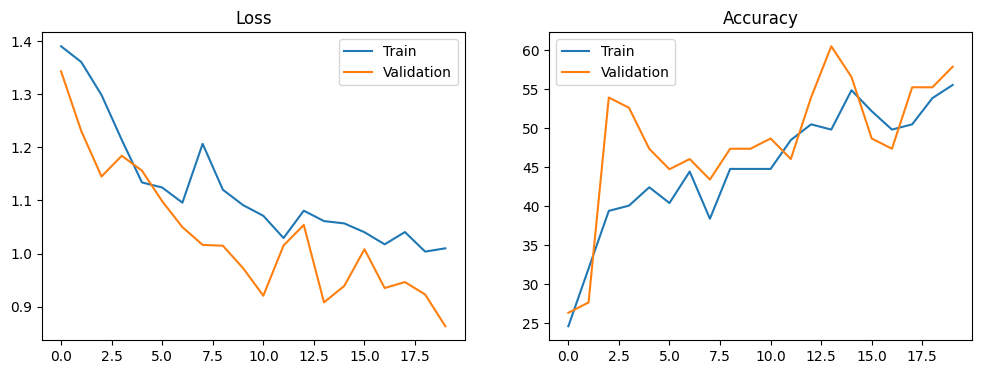

In [ ]:
model_aug = CNN(num_classes=4).to(device)

criterion_aug = nn.CrossEntropyLoss()
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)

history_aug = train_model(model_aug, train_loader_aug, val_loader, criterion_aug, optimizer_aug, device, num_epochs=20)

plot_history(history_aug)

A partir da aplicação desse modelo de CNN ao dataset com aumento de dados(pós dataaugmentation), foi possível tirar as seguintes conclusões, com base nesse treinamento:

**Acurácia de Treinamento:** começou em torno de 24,58% e aumentou gradualmente, atingindo 55,56% ao final da 20ª época.

**Acurácia de Validação:** iniciou com 26,32% e apresentou algumas melhorias, alcançando 57,89% na 20ª época.

**Perda de treinamento** começou em 1.390 e foi diminuindo ao longo das épocas, chegando a 1.010 na última época, embora tenha apresentado alguns aumentos, como na época 8.

**Perda de validação** variou ao longo das épocas, sem uma tendência clara de diminuição consistente, embora tenha caído para 0.863 no final.

Enfim, a acurácia de treinamento aumentou de forma gradual,da mesma forma que a acurácia de validação. Entretanto, ambas apresentaram oscilações durante as épocas. Assim, o desempenho do modelo indica que ele está melhorando, mas ainda tem espaço para melhorias significativas, especialmente na validação.

Essas oscilações podem indicar que o modelo está lutando para generalizar bem para dados não vistos. Algumas estratégias para melhorar ainda mais o desempenho é o uso em futuros treinamentos de técnicas de regularização, como o dropout que será aplicado posteriormente, otimização de hiperparâmetros ou mais dados para treinamento (aplicação de novos critérios no data augmentation).

É importante frisar que devido ao limite temporal e após inúmeras tentativas no learning rate, tipos de optimizadores, aumento de filtros, camadas, esses foram os melhores resultados encontrados. Aqui foi aplicado data augmentation, mas não houve a melhoria significativa dos resultados, pelo contrário, houve a redução da acurácia, quando comparado com o modelo anterior.

# **6.2 Segunda Tentativa - Com Dropout**

In [ ]:
class CNN2(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 2 * 2, 128)
        self.dropout1 = nn.Dropout(0.4)  # Adicionando dropout
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2, stride=2, padding=0)
        x = x.view(-1, 64 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Aplicando dropout
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Inicialização do modelo
model2 = CNN2(num_classes=4).to(device)

# Exemplo de entrada
x = torch.randn(1, 3, 224, 224).to(device)
print(model2(x).shape)

torch.Size([1, 4])


**6.2.1 Aplicação do CNN -dataset sem aumento de dados**

100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


Epoch 1, Train Loss: 1.384, Train Accuracy: 29.97%
Epoch 1, Val Loss: 1.332, Val Accuracy: 38.16%


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


Epoch 2, Train Loss: 1.288, Train Accuracy: 38.38%
Epoch 2, Val Loss: 1.113, Val Accuracy: 50.00%


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch 3, Train Loss: 1.057, Train Accuracy: 58.25%
Epoch 3, Val Loss: 0.939, Val Accuracy: 52.63%


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Epoch 4, Train Loss: 0.993, Train Accuracy: 56.90%
Epoch 4, Val Loss: 0.835, Val Accuracy: 60.53%


100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


Epoch 5, Train Loss: 0.922, Train Accuracy: 56.57%
Epoch 5, Val Loss: 0.780, Val Accuracy: 78.95%


100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


Epoch 6, Train Loss: 0.835, Train Accuracy: 65.99%
Epoch 6, Val Loss: 0.736, Val Accuracy: 73.68%


100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Epoch 7, Train Loss: 0.731, Train Accuracy: 71.04%
Epoch 7, Val Loss: 0.539, Val Accuracy: 78.95%


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


Epoch 8, Train Loss: 0.652, Train Accuracy: 75.42%
Epoch 8, Val Loss: 0.600, Val Accuracy: 72.37%


100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


Epoch 9, Train Loss: 0.594, Train Accuracy: 75.42%
Epoch 9, Val Loss: 0.504, Val Accuracy: 82.89%


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


Epoch 10, Train Loss: 0.538, Train Accuracy: 77.78%
Epoch 10, Val Loss: 0.445, Val Accuracy: 77.63%


100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


Epoch 11, Train Loss: 0.517, Train Accuracy: 79.80%
Epoch 11, Val Loss: 0.421, Val Accuracy: 84.21%


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Epoch 12, Train Loss: 0.408, Train Accuracy: 85.52%
Epoch 12, Val Loss: 0.363, Val Accuracy: 86.84%


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


Epoch 13, Train Loss: 0.351, Train Accuracy: 88.22%
Epoch 13, Val Loss: 0.260, Val Accuracy: 88.16%


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


Epoch 14, Train Loss: 0.349, Train Accuracy: 86.20%
Epoch 14, Val Loss: 0.335, Val Accuracy: 86.84%


100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


Epoch 15, Train Loss: 0.296, Train Accuracy: 88.22%
Epoch 15, Val Loss: 0.324, Val Accuracy: 86.84%


100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Epoch 16, Train Loss: 0.268, Train Accuracy: 91.25%
Epoch 16, Val Loss: 0.337, Val Accuracy: 89.47%


100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


Epoch 17, Train Loss: 0.300, Train Accuracy: 89.56%
Epoch 17, Val Loss: 0.365, Val Accuracy: 86.84%


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


Epoch 18, Train Loss: 0.248, Train Accuracy: 90.57%
Epoch 18, Val Loss: 0.389, Val Accuracy: 85.53%


100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


Epoch 19, Train Loss: 0.146, Train Accuracy: 94.95%
Epoch 19, Val Loss: 0.264, Val Accuracy: 88.16%


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Epoch 20, Train Loss: 0.146, Train Accuracy: 94.61%
Epoch 20, Val Loss: 0.385, Val Accuracy: 90.79%


100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


Epoch 21, Train Loss: 0.135, Train Accuracy: 95.29%
Epoch 21, Val Loss: 0.325, Val Accuracy: 89.47%


100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


Epoch 22, Train Loss: 0.072, Train Accuracy: 97.98%
Epoch 22, Val Loss: 0.280, Val Accuracy: 88.16%


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


Epoch 23, Train Loss: 0.105, Train Accuracy: 96.30%
Epoch 23, Val Loss: 0.282, Val Accuracy: 92.11%


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Epoch 24, Train Loss: 0.187, Train Accuracy: 93.27%
Epoch 24, Val Loss: 0.369, Val Accuracy: 90.79%


100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


Epoch 25, Train Loss: 0.083, Train Accuracy: 96.30%
Epoch 25, Val Loss: 0.253, Val Accuracy: 89.47%


100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


Epoch 26, Train Loss: 0.079, Train Accuracy: 97.31%
Epoch 26, Val Loss: 0.298, Val Accuracy: 90.79%


100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


Epoch 27, Train Loss: 0.056, Train Accuracy: 98.65%
Epoch 27, Val Loss: 0.324, Val Accuracy: 89.47%


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch 28, Train Loss: 0.045, Train Accuracy: 98.65%
Epoch 28, Val Loss: 0.349, Val Accuracy: 89.47%


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


Epoch 29, Train Loss: 0.016, Train Accuracy: 99.66%
Epoch 29, Val Loss: 0.297, Val Accuracy: 90.79%


100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


Epoch 30, Train Loss: 0.027, Train Accuracy: 98.65%
Epoch 30, Val Loss: 0.399, Val Accuracy: 89.47%
Treinamento concluído


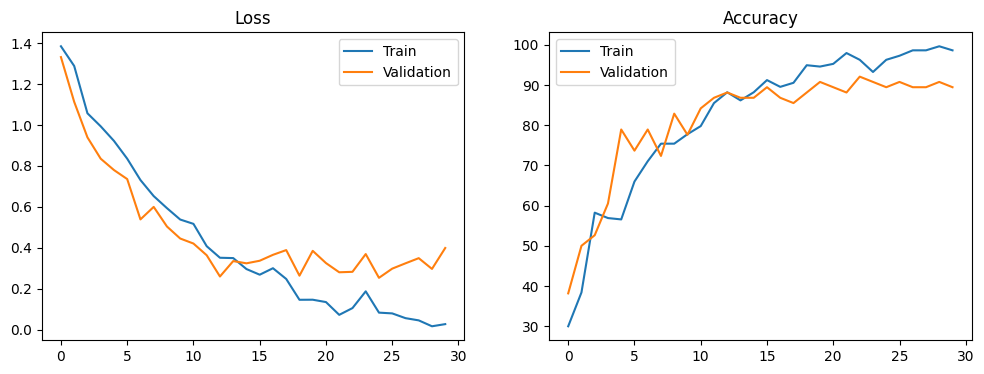

In [ ]:
model_no_aug2 = CNN2(num_classes=4).to(device)

criterion_no_aug2 = nn.CrossEntropyLoss() # Função de perda para múltiplas classes
optimizer_no_aug2 = optim.Adam(model_no_aug2.parameters(), lr=0.001)

history_no_aug2 = train_model(model_no_aug2, train_loader_no_aug, val_loader, criterion_no_aug2, optimizer_no_aug2, device, num_epochs=30)

plot_history(history_no_aug2)

A partir da aplicação desse modelo de CNN com dropout ao dataset sem aumento de dados, foi possível tirar as seguintes conclusões, com base nesse treinamento:

Os resultados de treinamento e validação ao longo de 30 épocas mostram um bom desempenho.

**Acurácia de Treinamento:** a acurácia de treinamento começou em 29,97% e aumentou de forma significativa ao longo das épocas, com algumas oscilações. Atingiu 99,66% na 29ª época, o que sugere que o modelo está aprendendo bem os dados de treinamento.

**Acurácia de Validação:** a acurácia de validação começou em 38,16% e apresentou um aumento gradual, alcançando 90,79% na 30ª época, o que é um bom sinal de que o modelo está generalizando melhor ao longo do treinamento.

**Perda de Treinamento:** a perda de treinamento iniciou em 1.384 e foi diminuindo significativamente, alcançando 0.027 no final, indicando que o modelo se ajustou muito bem aos dados de treinamento, com poucas oscilações.

**Perda de Validação:** a perda de validação também diminuiu de 1.332 para 0.399 na 30ª época, mostrando que o modelo não só aprendeu bem, mas também conseguiu manter um bom desempenho em dados de validação, apesar de algumas oscilações.

Enfim, a acurácia de validação teve um aumento muito bom ao longo das épocas e chegou perto de 91% no final, o que indica uma boa generalização do modelo. Embora o modelo tenha alcançado um desempenho impressionante nos dados de treinamento, a validação mostrou algumas flutuações (por exemplo, no final da 28ª época), o que pode ser indicativo de algum leve overfitting ou necessidade de ajuste fino.

Para buscar resolver possível overfitting já foi aplicado o dropout. Em outros treinamentos desse dataset pode também ser aplicado L2 regularization ou early stopping. Posteriormente serão aplicadas outras arquiteturas com modelos pré-treinados.







**6.2.2 Aplicação do CNN -com dropout e dataset com aumento de dados**

100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 1, Train Loss: 1.386, Train Accuracy: 24.58%
Epoch 1, Val Loss: 1.385, Val Accuracy: 25.00%


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Epoch 2, Train Loss: 1.374, Train Accuracy: 30.30%
Epoch 2, Val Loss: 1.347, Val Accuracy: 27.63%


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch 3, Train Loss: 1.310, Train Accuracy: 36.70%
Epoch 3, Val Loss: 1.161, Val Accuracy: 47.37%


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Epoch 4, Train Loss: 1.224, Train Accuracy: 37.04%
Epoch 4, Val Loss: 1.043, Val Accuracy: 47.37%


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 5, Train Loss: 1.185, Train Accuracy: 42.76%
Epoch 5, Val Loss: 0.973, Val Accuracy: 47.37%


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Epoch 6, Train Loss: 1.116, Train Accuracy: 42.76%
Epoch 6, Val Loss: 0.946, Val Accuracy: 52.63%


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Epoch 7, Train Loss: 1.139, Train Accuracy: 43.10%
Epoch 7, Val Loss: 0.947, Val Accuracy: 51.32%


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch 8, Train Loss: 1.144, Train Accuracy: 43.77%
Epoch 8, Val Loss: 0.979, Val Accuracy: 50.00%


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Epoch 9, Train Loss: 1.155, Train Accuracy: 43.43%
Epoch 9, Val Loss: 0.981, Val Accuracy: 57.89%


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch 10, Train Loss: 1.095, Train Accuracy: 42.09%
Epoch 10, Val Loss: 1.062, Val Accuracy: 50.00%


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Epoch 11, Train Loss: 1.082, Train Accuracy: 47.47%
Epoch 11, Val Loss: 0.981, Val Accuracy: 55.26%


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Epoch 12, Train Loss: 1.075, Train Accuracy: 48.48%
Epoch 12, Val Loss: 0.980, Val Accuracy: 52.63%


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch 13, Train Loss: 1.120, Train Accuracy: 44.44%
Epoch 13, Val Loss: 0.942, Val Accuracy: 60.53%


100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Epoch 14, Train Loss: 1.070, Train Accuracy: 47.14%
Epoch 14, Val Loss: 0.987, Val Accuracy: 60.53%


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch 15, Train Loss: 1.092, Train Accuracy: 49.49%
Epoch 15, Val Loss: 0.944, Val Accuracy: 57.89%


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Epoch 16, Train Loss: 1.085, Train Accuracy: 46.46%
Epoch 16, Val Loss: 0.941, Val Accuracy: 59.21%


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch 17, Train Loss: 1.096, Train Accuracy: 50.17%
Epoch 17, Val Loss: 0.936, Val Accuracy: 53.95%


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Epoch 18, Train Loss: 1.110, Train Accuracy: 47.47%
Epoch 18, Val Loss: 0.900, Val Accuracy: 56.58%


100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Epoch 19, Train Loss: 1.009, Train Accuracy: 53.87%
Epoch 19, Val Loss: 1.089, Val Accuracy: 57.89%


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch 20, Train Loss: 1.077, Train Accuracy: 47.81%
Epoch 20, Val Loss: 0.970, Val Accuracy: 60.53%


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Epoch 21, Train Loss: 1.019, Train Accuracy: 52.53%
Epoch 21, Val Loss: 1.016, Val Accuracy: 48.68%


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch 22, Train Loss: 1.020, Train Accuracy: 50.17%
Epoch 22, Val Loss: 0.866, Val Accuracy: 63.16%


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Epoch 23, Train Loss: 1.031, Train Accuracy: 54.55%
Epoch 23, Val Loss: 0.926, Val Accuracy: 63.16%


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Epoch 24, Train Loss: 1.030, Train Accuracy: 53.87%
Epoch 24, Val Loss: 0.898, Val Accuracy: 63.16%


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 25, Train Loss: 1.028, Train Accuracy: 52.53%
Epoch 25, Val Loss: 0.947, Val Accuracy: 59.21%


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Epoch 26, Train Loss: 1.072, Train Accuracy: 51.52%
Epoch 26, Val Loss: 0.961, Val Accuracy: 50.00%


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch 27, Train Loss: 0.970, Train Accuracy: 53.20%
Epoch 27, Val Loss: 0.920, Val Accuracy: 56.58%


100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Epoch 28, Train Loss: 1.059, Train Accuracy: 51.52%
Epoch 28, Val Loss: 0.925, Val Accuracy: 57.89%


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 29, Train Loss: 0.965, Train Accuracy: 55.22%
Epoch 29, Val Loss: 0.845, Val Accuracy: 67.11%


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 30, Train Loss: 1.008, Train Accuracy: 59.60%
Epoch 30, Val Loss: 0.946, Val Accuracy: 61.84%
Treinamento concluído


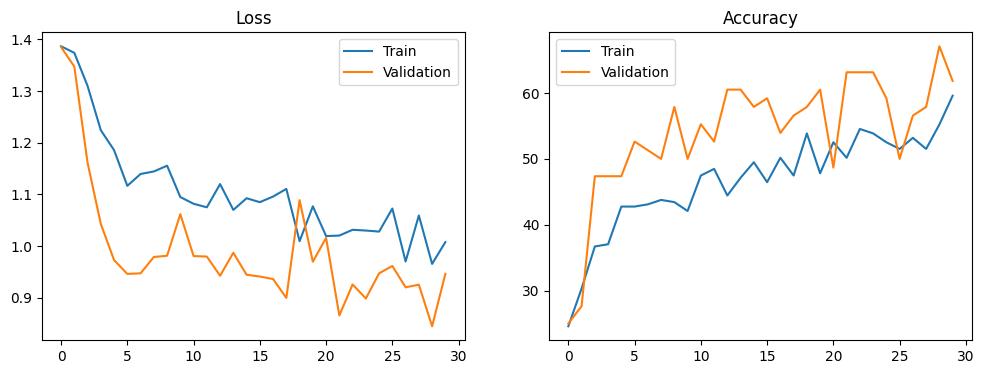

In [ ]:
model_aug2 = CNN2(num_classes=4).to(device)

criterion_aug2 = nn.CrossEntropyLoss()
optimizer_aug2 = optim.Adam(model_aug2.parameters(), lr=0.001)

history_aug2 = train_model(model_aug2, train_loader_aug, val_loader, criterion_aug2, optimizer_aug2, device, num_epochs=30)

plot_history(history_aug2)

A partir da aplicação desse modelo de CNN com dropout ao dataset com aumento de dados, foi possível tirar as seguintes conclusões, com base nesse treinamento:

Os resultados de treinamento e validação ao longo de 30 épocas mostraram que o modelo tem enfrentado dificuldades para melhorar de forma consistente, especialmente na validação.

**Acurácia de Treinamento:** a acurácia de treinamento começou em 24,58% e aumentou lentamente ao longo das épocas, alcançando 59,60% na 30ª época.

**Perda de Treinamento:** a perda de treinamento começou em 1.386 e foi diminuindo de forma gradual, com algumas oscilações, caindo para 1.008 na 30ª época.

**Acurácia de Validação:** a acurácia de validação foi inicialmente baixa (25%) e teve um aumento muito lento, com flutuações ao longo das épocas. A maior acurácia de validação foi 67,11% na 29ª época, mas foi seguida de uma leve queda para 61,84% na última época.

**Perda de Validação:** A perda de validação começou em 1.385 e diminuiu um pouco nas primeiras épocas, mas depois estabilizou com algumas flutuações. A última perda de validação foi 0.946, que mostra uma melhoria modesta, mas não tão consistente quanto a acurácia de treinamento.

Enfim, a acurácia de treinamento e validação não atingiram valores elevados, sugerindo que o modelo pode estar sofrendo de underfitting (não aprendendo o suficiente). Para buscar resolver esse problema, pode ser importante aumentar ainda mais os dados de treinamento (novos critérios de data augmentation) ou modificar a arquitetura do modelo.

Ademais, a acurácia de validação apresentou poucas melhorias substanciais, sugerindo que o modelo pode não estar generalizando bem para novos dados (overfitting). A maior acurácia de validação foi em torno de 67%, mas o desempenho oscilou em torno de 60% no final.


# **7. Aplicação de Modelos Pré-Treinados**


**7.1 Definição das transformações com e sem data augmentation e datasets (treino e validação)**

In [13]:
train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
train_set_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)
train_loader_aug = DataLoader(train_set_aug, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

**7.2 Definição da função de treinamento e avaliação**

In [14]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    return epoch_loss, accuracy


def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    return epoch_loss, accuracy

**7.3. Carregamento dos Modelos com Pesos Pré-Treinados**

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar ResNet50 com pesos pré-treinados
resnet_model_v1 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet_model_v2 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Carregar VGG16 com pesos pré-treinados
vgg_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Modificar a camada final para o número de classes do seu dataset
num_classes = len(train_set_no_aug.classes)  # ou train_set_aug.classes, depende do seu dataset
print(num_classes) #o correto é 4, pois são 4 tipos de frutas

resnet_model_v1.fc = nn.Linear(resnet_model_v1.fc.in_features, num_classes)
resnet_model_v2.fc = nn.Linear(resnet_model_v2.fc.in_features, num_classes)
vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, num_classes)

# Transferir os modelos para o dispositivo (GPU ou CPU)
resnet_model_v1 = resnet_model_v1.to(device)
resnet_model_v2 = resnet_model_v2.to(device)
vgg_model = vgg_model.to(device)


4


In [ ]:
print(resnet_model_v1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
print(resnet_model_v2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**7.4 Definição do otimizador e critério de perda**

In [16]:
criterion = nn.CrossEntropyLoss()

optimizer_resnet_v1 = optim.Adam(resnet_model_v1.parameters(), lr=0.001)
optimizer_resnet_v2 = optim.Adam(resnet_model_v2.parameters(), lr=0.001)
optimizer_vgg = optim.Adam(vgg_model.parameters(), lr=0.001)

# **7.5 Treinamento e Avaliação do Modelo Pré-Treinado**

# **7.5.1 ResNet50 (versão 1)**

**7.5.1.1 Aplicado na Base de Treino sem aumento**

In [ ]:
import matplotlib.pyplot as plt

# Listas para armazenar as métricas de cada época
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 20

# Treinamento e Avaliação do ResNet50 (versão 1) #é aplicado na base de treino sem aumento
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(resnet_model_v1, train_loader_no_aug, criterion, optimizer_resnet_v1, device)
    val_loss, val_acc = evaluate(resnet_model_v1, val_loader, criterion, device)

    # Armazenar os resultados
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Exibir os resultados
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/20
Train Loss: 0.6411, Train Accuracy: 74.07%
Val Loss: 405.9476, Val Accuracy: 34.21%
Epoch 2/20
Train Loss: 0.4279, Train Accuracy: 84.18%
Val Loss: 14.3334, Val Accuracy: 64.47%
Epoch 3/20
Train Loss: 0.3657, Train Accuracy: 88.22%
Val Loss: 16.5127, Val Accuracy: 64.47%
Epoch 4/20
Train Loss: 0.6106, Train Accuracy: 90.24%
Val Loss: 3.7826, Val Accuracy: 75.00%
Epoch 5/20
Train Loss: 0.4831, Train Accuracy: 85.52%
Val Loss: 538.7583, Val Accuracy: 40.79%
Epoch 6/20
Train Loss: 0.5656, Train Accuracy: 82.49%
Val Loss: 2.6063, Val Accuracy: 68.42%
Epoch 7/20
Train Loss: 0.3128, Train Accuracy: 91.25%
Val Loss: 0.6000, Val Accuracy: 86.84%
Epoch 8/20
Train Loss: 0.2189, Train Accuracy: 93.94%
Val Loss: 0.3272, Val Accuracy: 90.79%
Epoch 9/20
Train Loss: 0.1751, Train Accuracy: 91.58%
Val Loss: 0.2996, Val Accuracy: 90.79%
Epoch 10/20
Train Loss: 0.1756, Train Accuracy: 92.93%
Val Loss: 0.3545, Val Accuracy: 90.79%
Epoch 11/20
Train Loss: 0.2565, Train Accuracy: 96.30%
Val Loss

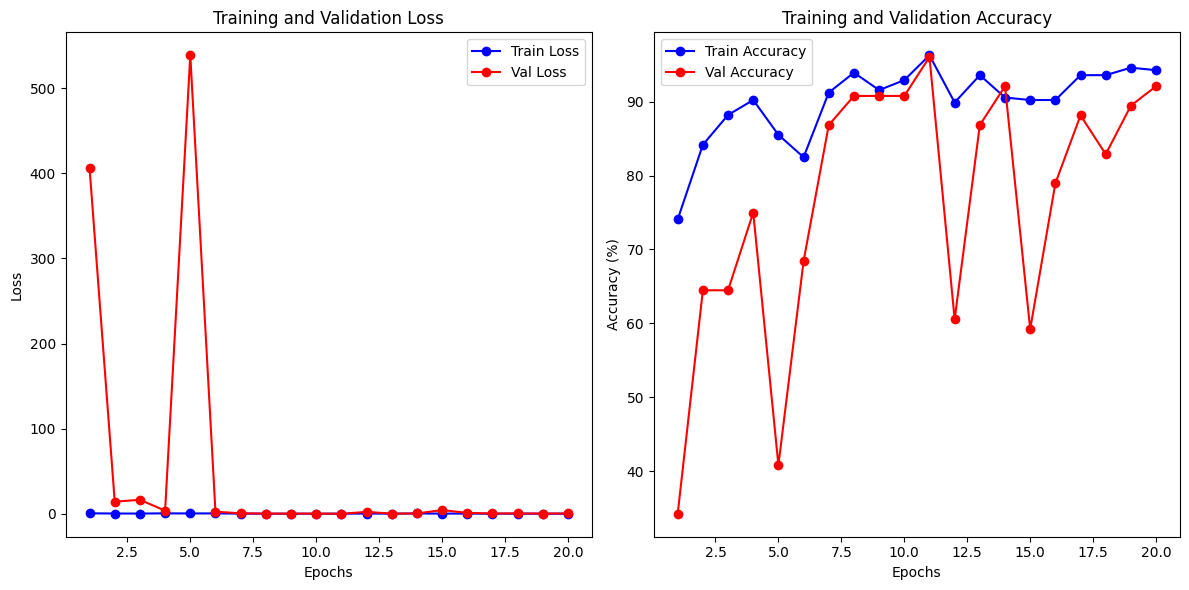

In [ ]:
# Plotando os gráficos
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

A partir da aplicação desse modelo ResNet50 (versão 1) ao dataset sem aumento de dados, foi possível tirar as seguintes conclusões, com base nesse treinamento:

**Acurácia de Treinamento:** começou em 74,07% na primeira época e aumentou consistentemente, alcançando 94,28% na última época. Isso indica que o modelo está aprendendo bem a partir dos dados de treinamento.

**Perda de Treinamento:** a perda de treinamento começou em 0,6411 na primeira época e foi reduzida ao longo das épocas, chegando a 0,1965 na última época. A diminuição da perda mostra que o modelo está melhorando seu desempenho no treinamento, mas com oscilações.

**Acurácia de Validação:** a acurácia de validação começou em 34,21% na primeira época, mas teve um aumento significativo ao longo do tempo. Ela atingiu seu ponto mais alto em 96,05% na 11ª época, depois estabilizou em torno de 89-92% nas últimas épocas. A oscilação após a 11ª época pode sugerir que o modelo está passando por algum overfitting ou que os dados de validação têm características diferentes dos dados de treinamento.

**Perda de Validação:** A perda de validação começou alta em 405,9476 na primeira época, mas caiu consideravelmente até 0,0867 na 11ª época, refletindo uma boa adaptação aos dados de validação. Após a 11ª época, houve flutuações nas perdas de validação, o que pode indicar que o modelo está tendo dificuldades para generalizar a partir dos dados de validação.

Enfim, o modelo apresentou um ótimo desempenho em treinamento mas algumas oscilações na acurácia e perda de validação, especialmente após a 11ª época, o que indica que pode estar ocorrendo overfitting. Ademais, esse desempenho de validação flutuante pode indicar que o modelo precisa de ajustes nos hiperparâmetros ou de mais dados de validação, pois foram apenas 20 por espécie.

Outras medidas para buscar melhorar esse modelo em outros treinamentos são aplicações de técnicas de regularização (dropout ou L2 regularization), ajustar novas taxas de aprendizados ou usar uma abordagem de learning rate schedule (diminuição gradual da taxa de aprendizado), early stopping (interrupção do treinamento quando a performance de validação começar a piorar, prevenindo o overfitting e economizando tempo computacional) e aumento de Dados (data augmentation). Esse último será realizado na próxima etapa.


**7.5.1.2 Aplicado na Base de Treino com aumento de dados**

In [ ]:
# Listas para armazenar as métricas de cada época
train_losses2 = []
train_accuracies2= []
val_losses2 = []
val_accuracies2 = []

num_epochs = 20

# Treinamento e Avaliação do ResNet50 (versão 1) #é aplicado na base de treino sem aumento
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(resnet_model_v1, train_loader_aug, criterion, optimizer_resnet_v1, device)
    val_loss, val_acc = evaluate(resnet_model_v1, val_loader, criterion, device)

    # Armazenar os resultados
    train_losses2.append(train_loss)
    train_accuracies2.append(train_acc)
    val_losses2.append(val_loss)
    val_accuracies2.append(val_acc)

    # Exibir os resultados
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/20
Train Loss: 1.7806, Train Accuracy: 47.47%
Val Loss: 1.2930, Val Accuracy: 56.58%
Epoch 2/20
Train Loss: 1.1199, Train Accuracy: 56.23%
Val Loss: 0.6512, Val Accuracy: 73.68%
Epoch 3/20
Train Loss: 1.0445, Train Accuracy: 60.27%
Val Loss: 0.7847, Val Accuracy: 81.58%
Epoch 4/20
Train Loss: 0.7908, Train Accuracy: 69.02%
Val Loss: 0.4983, Val Accuracy: 82.89%
Epoch 5/20
Train Loss: 0.8635, Train Accuracy: 62.29%
Val Loss: 0.4446, Val Accuracy: 86.84%
Epoch 6/20
Train Loss: 0.7592, Train Accuracy: 69.02%
Val Loss: 0.7170, Val Accuracy: 77.63%
Epoch 7/20
Train Loss: 0.7594, Train Accuracy: 66.67%
Val Loss: 0.5727, Val Accuracy: 78.95%
Epoch 8/20
Train Loss: 0.7643, Train Accuracy: 72.39%
Val Loss: 0.3742, Val Accuracy: 85.53%
Epoch 9/20
Train Loss: 0.7058, Train Accuracy: 69.36%
Val Loss: 0.2312, Val Accuracy: 92.11%
Epoch 10/20
Train Loss: 0.6091, Train Accuracy: 72.05%
Val Loss: 0.2992, Val Accuracy: 88.16%
Epoch 11/20
Train Loss: 0.6776, Train Accuracy: 73.40%
Val Loss: 0.35

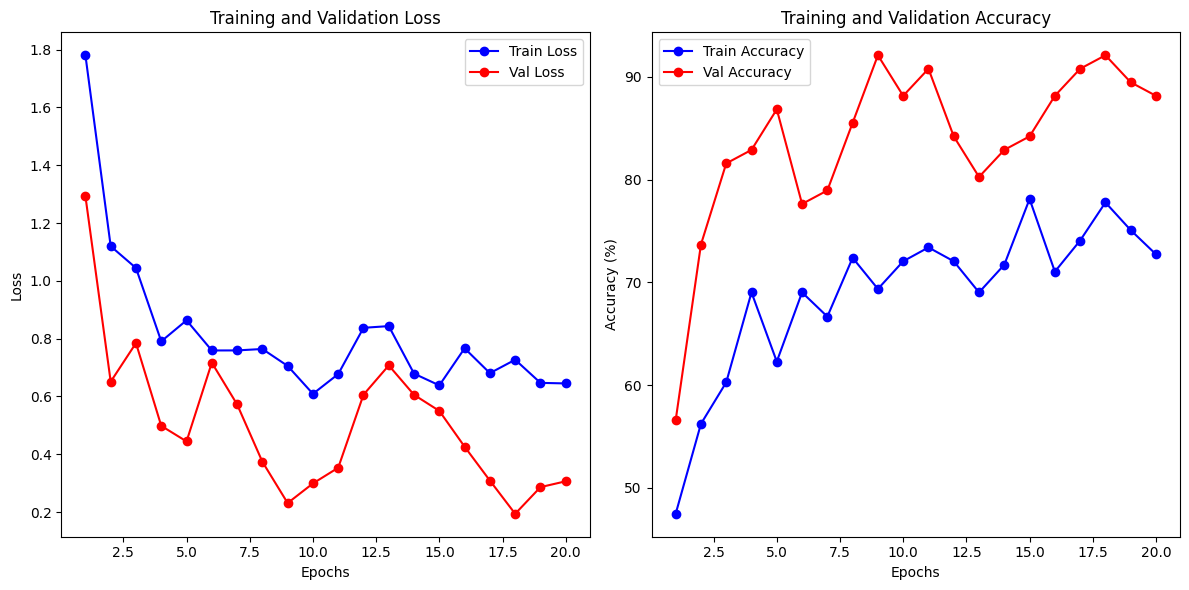

In [ ]:
# Plotando os gráficos
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses2, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses2, label='Val Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies2, label='Train Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies2, label='Val Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

A partir da aplicação desse modelo ResNet50 (versão 1) ao dataset com aumento de dados, foi possível tirar as seguintes conclusões, com base nesse treinamento:

O desempenho do modelo nas 20 épocas mostrou um progresso interessante e, em geral, melhorou seu desempenho tanto em termos de perda quanto de acurácia.

**Acurácia de treinamento:** começou em 47,47% na primeira época e teve uma melhoria até 78.11 % (época 15), depois teve algumas oscilações, chegando a 72,73% na última época. Embora tenha começado mais baixo, houve um aumento geral na acurácia de treinamento ao longo das épocas, com poucas oscilações no final,indicando que o modelo estava aprendendo a partir dos dados de treinamento.

**Perda de Treinamento:** a perda de treinamento começou alta em 1,7806 na primeira época e foi reduzida gradualmente até 0,6451 na última época. A diminuição consistente da perda de treinamento reflete uma aprendizagem bem-sucedida ao longo do tempo.

**Acurácia de Validação:** começou em 56,58% na primeira época e teve um aumento significativo, atingindo um pico de 92,11% nas 9ª e 18ª épocas. Após a 9ª época, houve uma pequena queda na acurácia, mas ela se manteve em torno de 88-90% nas últimas épocas. Essa estabilização sugere que o modelo atingiu um bom equilíbrio e foi capaz de generalizar bem para os dados de validação.

**Perda de Validação:** começou em 1,2930 na primeira época e diminuiu ao longo do tempo, alcançando seu ponto mais baixo de 0,1941 na 18ª época, o que é um sinal de bom desempenho em termos de generalização para dados não vistos.

Enfim, o modelo mostrou uma tendência geral de melhoria tanto em acurácia quanto em perda de validação. As flutuações nas últimas épocas podem ser indicativos de que o modelo está se aproximando de um ponto de saturação ou estabilidade em relação aos dados de validação.

A perda de treinamento continuou a diminuir, mas a acurácia de validação pareceu ter alcançado um pico e se estabilizou. Isso sugere que o modelo está se ajustando bem aos dados de validação sem grandes problemas de overfitting, pelo menos não significativos. Entretanto, seria importante a aplicação de outros testes e acompanhamento.

Esse modelo pré-pronto parece ter sido o melhor alcançado até o momento, com boa capacidade de generalização. Para buscar melhorar ainda mais o modelo em possíveis treinamentos - como aumentar a acurácia do treinamento - podem ser aplicadas regularização (dropout ou L2 regularization), ajustar novas taxas de aprendizado, experimentar redução gradual da taxa de aprendizado (learning rate scheduler) e early stopping.


# **7.5.2 ResNet50 (versão 2)**

**7.5.2.1 Aplicado na Base de Treino sem aumento de dados**

In [ ]:
# Listas para armazenar as métricas de cada época
train_losses3 = []
train_accuracies3 = []
val_losses3 = []
val_accuracies3 = []

num_epochs = 20

# Treinamento e Avaliação do ResNet50 (versão 2)
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(resnet_model_v2, train_loader_no_aug, criterion, optimizer_resnet_v2, device)
    val_loss, val_acc = evaluate(resnet_model_v2, val_loader, criterion, device)

    # Armazenar os resultados
    train_losses3.append(train_loss)
    train_accuracies3.append(train_acc)
    val_losses3.append(val_loss)
    val_accuracies3.append(val_acc)

    # Exibir os resultados
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/20
Train Loss: 0.5328, Train Accuracy: 82.49%
Val Loss: 0.1067, Val Accuracy: 94.74%
Epoch 2/20
Train Loss: 0.2685, Train Accuracy: 95.29%
Val Loss: 1.7660, Val Accuracy: 89.47%
Epoch 3/20
Train Loss: 0.2436, Train Accuracy: 94.95%
Val Loss: 1.9622, Val Accuracy: 80.26%
Epoch 4/20
Train Loss: 0.2328, Train Accuracy: 94.61%
Val Loss: 0.2328, Val Accuracy: 94.74%
Epoch 5/20
Train Loss: 0.0988, Train Accuracy: 97.64%
Val Loss: 0.2755, Val Accuracy: 90.79%
Epoch 6/20
Train Loss: 0.0765, Train Accuracy: 97.98%
Val Loss: 0.3254, Val Accuracy: 94.74%
Epoch 7/20
Train Loss: 0.1265, Train Accuracy: 96.63%
Val Loss: 0.4248, Val Accuracy: 90.79%
Epoch 8/20
Train Loss: 0.1003, Train Accuracy: 97.98%
Val Loss: 0.2232, Val Accuracy: 93.42%
Epoch 9/20
Train Loss: 0.0627, Train Accuracy: 97.98%
Val Loss: 0.0651, Val Accuracy: 97.37%
Epoch 10/20
Train Loss: 0.2033, Train Accuracy: 96.97%
Val Loss: 1.4775, Val Accuracy: 72.37%
Epoch 11/20
Train Loss: 0.2665, Train Accuracy: 94.61%
Val Loss: 1.21

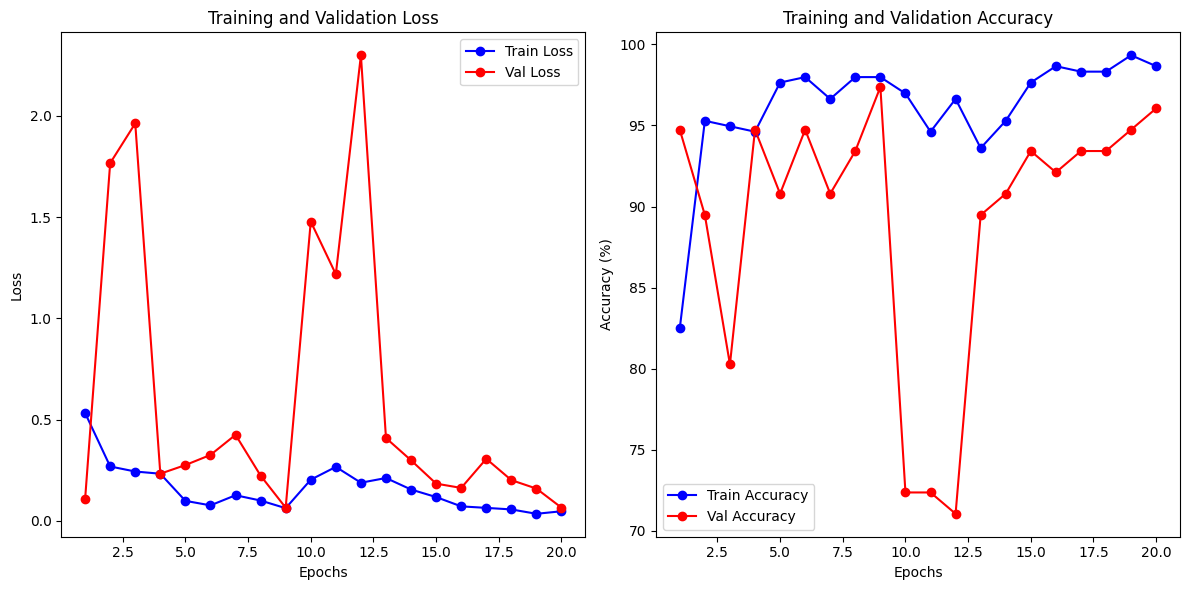

In [ ]:
# Plotando os gráficos
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses3, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses3, label='Val Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies3, label='Train Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies3, label='Val Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

A partir da aplicação desse modelo ResNet50 (versão 2) ao dataset sem aumento de dados, foi possível tirar as seguintes conclusões, com base nesse treinamento:

O desempenho do modelo nas 20 épocas apresenta uma série de flutuações, mas também reflete alguns picos de melhoria de acurácia, em termos de  treinamento e validação.

**Acurácia de Treinamento:** o modelo iniciou com uma boa acurácia de 82,49% e, ao longo das épocas, alcançou valores muito altos, com 99,33% na 19ª época. Isso indica que o modelo estava aprendendo rápido durante o treinamento.

**Perda de Treinamento:** começou em 0,5328 na primeira época e diminuiu ao longo do treinamento, com valores que variaram entre 0,0349 e 0,2665. Isso reflete um bom ajuste aos dados de treinamento.

**Acurácia de Validação:** apresentou alguns picos e quedas, mas a tendência geral foi de melhorias. Ela começou em 94,74% na 1ª época, caiu um pouco nas 2ª e 3ª épocas, mas logo se recuperou, alcançando 97,37% na 9ª época. Depois, houve uma leve queda nas épocas 10 a 13, com a acurácia estabilizando em torno de 93% até a 20ª época.

**Perda de Validação:** também variou ao longo das épocas, com uma queda inicial até atingir seu ponto mais baixo de 0,0651 na 9ª e 20ª épocas. No entanto, houve aumentos significativos na perda de validação nas épocas 2 e 3, assim como 10 a 12, o que indica que o modelo pode ter começado a enfrentar dificuldades de generalização nesses pontos.

Enfim, as primeiras 9 épocas mostraram um ótimo desempenho de validação, exceto épocas 2 e 3, com a perda caindo e a acurácia subindo. As flutuações observadas a partir da 10ª época, com a perda de validação aumentando e a acurácia caindo temporariamente, podem indicar que o modelo começou a sobreajustar aos dados de treinamento. Nas últimas épocas (de 13 a 20), o modelo estabilizou seu desempenho com boas métricas de validação, geralmente entre 90-97%.

O modelo apresentou algumas flutuações na acurácia de validação e perda de validação, especialmente nas épocas intermediárias. Isso pode indicar algum grau de overfitting ou instabilidade no treinamento. A diferença notável entre as métricas de treinamento e validação nas épocas iniciais sugere que o modelo tem grande capacidade de aprender com os dados de treinamento, mas talvez não tenha generalizado de maneira tão estável em todos os pontos.

Este modelo foi o que teve mais flutuações, de modo que seria importante novos treinamentos, com aplicações de regularização (dropout ou L2 regularization), taxa de Aprendizado - com redução progressiva para estabilizar ainda mais o treinamento nas últimas épocas -e early stopping.

Esses novos treinamentos não serão realizados no momento devido a limitação temporal dos discentes, mas será aplicado esse modelo na base de dados que teve ampliação através do data augmentation para buscar melhorias.


**7.5.2.1 Aplicado na Base de Treino com aumento de dados**

In [ ]:

# Listas para armazenar as métricas de cada época
train_losses4 = []
train_accuracies4 = []
val_losses4 = []
val_accuracies4 = []

num_epochs = 20

# Treinamento e Avaliação do ResNet50 (versão 2)
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(resnet_model_v2, train_loader_aug, criterion, optimizer_resnet_v2, device)
    val_loss, val_acc = evaluate(resnet_model_v2, val_loader, criterion, device)

    # Armazenar os resultados
    train_losses4.append(train_loss)
    train_accuracies4.append(train_acc)
    val_losses4.append(val_loss)
    val_accuracies4.append(val_acc)

    # Exibir os resultados
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/20
Train Loss: 1.4640, Train Accuracy: 64.65%
Val Loss: 9.4789, Val Accuracy: 46.05%
Epoch 2/20
Train Loss: 1.1841, Train Accuracy: 56.90%
Val Loss: 1.0556, Val Accuracy: 60.53%
Epoch 3/20
Train Loss: 0.8473, Train Accuracy: 66.33%
Val Loss: 0.7752, Val Accuracy: 76.32%
Epoch 4/20
Train Loss: 0.9052, Train Accuracy: 63.97%
Val Loss: 0.4078, Val Accuracy: 77.63%
Epoch 5/20
Train Loss: 0.7170, Train Accuracy: 71.38%
Val Loss: 0.4002, Val Accuracy: 84.21%
Epoch 6/20
Train Loss: 0.8459, Train Accuracy: 70.71%
Val Loss: 0.3421, Val Accuracy: 88.16%
Epoch 7/20
Train Loss: 0.7196, Train Accuracy: 72.39%
Val Loss: 0.6167, Val Accuracy: 73.68%
Epoch 8/20
Train Loss: 0.5852, Train Accuracy: 76.77%
Val Loss: 0.2952, Val Accuracy: 88.16%
Epoch 9/20
Train Loss: 0.8034, Train Accuracy: 70.03%
Val Loss: 0.6568, Val Accuracy: 82.89%
Epoch 10/20
Train Loss: 0.7745, Train Accuracy: 74.75%
Val Loss: 0.3100, Val Accuracy: 88.16%
Epoch 11/20
Train Loss: 0.7155, Train Accuracy: 74.75%
Val Loss: 0.34

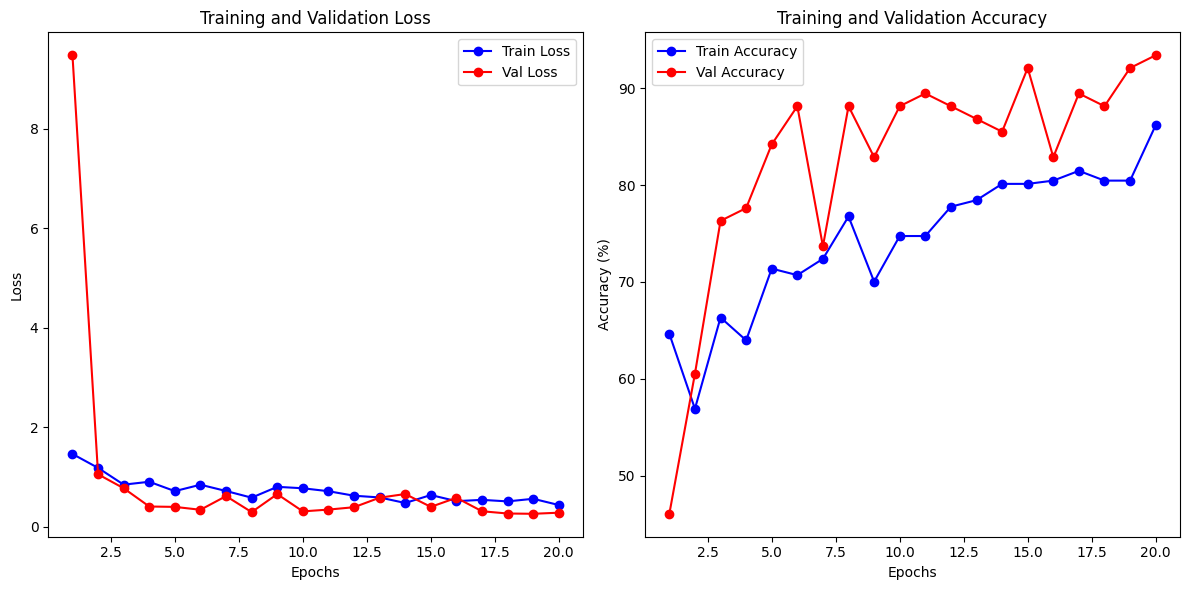

In [ ]:
# Plotando os gráficos
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses4, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses4, label='Val Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies4, label='Train Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies4, label='Val Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

A partir da aplicação desse modelo ResNet50 (versão 2) ao dataset com aumento de dados, foi possível tirar as seguintes conclusões, com base nesse treinamento:

**Acurácia de Treinamento:** o modelo tem mostrado uma evolução consistente ao longo das 20 épocas de treinamento. Começou com 64,65% na 1ª época e subiu até 86,20% na 20ª época. Isso mostra que o modelo foi capaz de aprender e se ajustar bem aos dados de treinamento.

**Perda de Treinamento:** começou em 1.4640 na 1ª época e foi reduzida gradualmente para 0.4377 na última época. Essa redução indica que o modelo está fazendo um bom trabalho em minimizar o erro no treinamento, apesar de algumas oscilações.

**Acurácia de Validação:** começou em 46,05% na 1ª época e aumentou consideravelmente ao longo do treinamento, atingindo 93,42% na última época. Isso indica que o modelo não apenas aprendeu bem com os dados de treinamento, mas também foi capaz de generalizar de forma eficaz, apesar de algumas oscilações.

**Perda de Validação:** A perda de validação começou muito alta em 9.4789 na 1ª época, mas foi reduzida ao longo das épocas, alcançando 0.2836 na última época. Embora tenha havido algumas flutuações (com picos nas épocas 7, 9, 13 e 16), a tendência geral foi de melhoria.

Enfim, o modelo foi melhorando ao longo das 20 épocas, tanto em termos de acurácia quanto de perda, com uma tendência geral de redução da perda de validação e aumento da acurácia. Houve algumas oscilações nas métricas de validação, o que indica que o modelo teve dificuldades para generalizar em certas épocas. No entanto, essas flutuações podem ser naturais especialmente quando o modelo está relacionado a diferentes padrões nos dados de validação.

Para buscar melhorar ainda mais o modelo em possíveis novos treinamentos - como aumentar a acurácia do treinamento - podem ser aplicadas regularização (dropout ou L2 regularization), ajustar novas taxas de aprendizado, experimentar redução gradual da taxa de aprendizado (learning rate scheduler) e early stopping.


# **7.5.3 VGG**

**7.5.3.1 Aplicado na Base de Treino sem aumento de dados**

In [ ]:

# Listas para armazenar as métricas de cada época
train_losses5 = []
train_accuracies5 = []
val_losses5 = []
val_accuracies5 = []

num_epochs = 20

# Treinamento e Avaliação do VGG
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(vgg_model, train_loader_no_aug, criterion, optimizer_vgg, device)
    val_loss, val_acc = evaluate(vgg_model, val_loader, criterion, device)

    # Armazenar os resultados
    train_losses5.append(train_loss)
    train_accuracies5.append(train_acc)
    val_losses5.append(val_loss)
    val_accuracies5.append(val_acc)

    # Exibir os resultados
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/20
Train Loss: 15.5492, Train Accuracy: 32.66%
Val Loss: 1.8410, Val Accuracy: 25.00%
Epoch 2/20
Train Loss: 1.5160, Train Accuracy: 26.60%
Val Loss: 3.3864, Val Accuracy: 25.00%
Epoch 3/20
Train Loss: 1.5997, Train Accuracy: 26.60%
Val Loss: 1.3971, Val Accuracy: 25.00%
Epoch 4/20
Train Loss: 1.4137, Train Accuracy: 19.19%
Val Loss: 1.3914, Val Accuracy: 25.00%
Epoch 5/20
Train Loss: 1.3957, Train Accuracy: 27.95%
Val Loss: 1.3918, Val Accuracy: 25.00%
Epoch 6/20
Train Loss: 1.4472, Train Accuracy: 23.57%
Val Loss: 1.3821, Val Accuracy: 26.32%
Epoch 7/20
Train Loss: 2.0315, Train Accuracy: 20.88%
Val Loss: 1.4294, Val Accuracy: 25.00%
Epoch 8/20
Train Loss: 1.4384, Train Accuracy: 24.92%
Val Loss: 1.3821, Val Accuracy: 25.00%
Epoch 9/20
Train Loss: 1.4015, Train Accuracy: 21.21%
Val Loss: 1.4018, Val Accuracy: 25.00%
Epoch 10/20
Train Loss: 1.3983, Train Accuracy: 21.89%
Val Loss: 1.3858, Val Accuracy: 25.00%
Epoch 11/20
Train Loss: 1.3924, Train Accuracy: 24.24%
Val Loss: 1.3

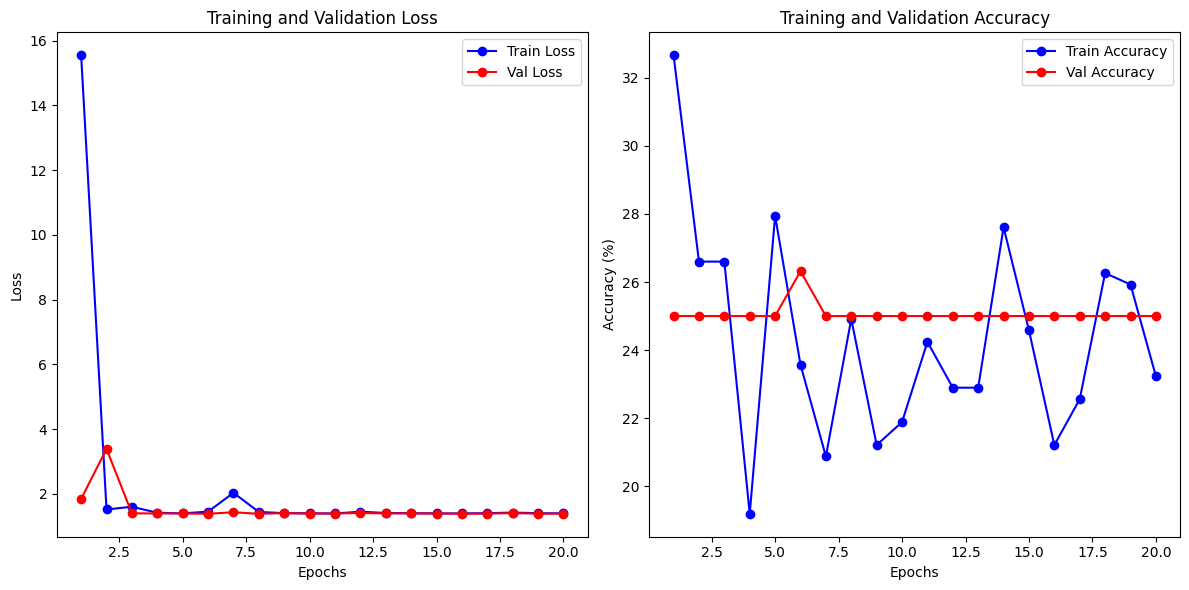

In [ ]:
# Plotando os gráficos
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses5, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses5, label='Val Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies5, label='Train Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies5, label='Val Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

A partir da aplicação desse modelo VGG ao dataset sem aumento de dados, foi possível tirar as seguintes conclusões, com base nesse treinamento:

Primeiro, o modelo parece estar enfrentando dificuldades para melhorar sua performance durante o treinamento, tanto nos dados de treinamento quanto nos dados de validação.

**Acurácia de Treinamento:** Começou em 32,66% na 1ª época e manteve-se em torno de 23% a 27% ao longo das épocas, indicando que o modelo não está aprendendo de forma eficiente com os dados de treinamento.

**Perda de Treinamento:** começou muito alta, com 15.5492 na 1ª época, mas foi reduzida para cerca de 1.3944 na última época. Apesar dessa diminuição na perda, o modelo não conseguiu melhorar sua acurácia.

**Acurácia de Validação:**  ficou consistentemente baixa, em 25% durante todo o treinamento. Isso sugere que o modelo não foi capaz de generalizar adequadamente, ou que os dados não foram suficientemente representativo do problema.

**Perda de Validação:** começou em 1.8410 e foi reduzida para 1.3881 na última época. Embora tenha havido uma leve diminuição na perda de validação, isso não foi acompanhado por uma melhora na acurácia, indicando que o modelo não conseguiu fazer avanços significativos no desempenho em dados não vistos.

Enfim, a falta de progresso nas métricas de treinamento e validação foi notório. Embora a perda de treinamento tenha diminuído, a acurácia tanto no treinamento quanto na validação permaneceu praticamente constante ao longo de todas as épocas. Portanto, o modelo está sofrendo dificuldades em se generalizar para os dados de validação, já que a acurácia permanece estagnada em 25%, bem como possível sobreajuste nos dados de validação, uma vez que a perda de validação não variou muito ao longo do tempo.

Esse desempenho tão insatisfatório é possivelmente resultado de vários fatores, que podem ser melhorados em futuros treinamentos, tais quais:

- Modelo inadequado, já que nos modelos ResNet50 - versão 1 e 2 houve bons resultados, apesar de várias flutuações, principalmente na base de dados sem data augmentation;

- Dados de Treinamento e validação: a quantidade de dados pode ser insuficiente. Esse aspecto será analisado posteriormente, pois haverá aumento de dados no próximo capítulo;

- Taxa de Aprendizado e Hiperparâmetros inadequadas, o que resultou em aprendizado lento;

- Regularização: necessidade da aplicação de técnicas de regularização, como mais camadas de dropout, o que pode ajudar a evitar o sobreajuste e melhorar a generalização ou L2 regularization.


**7.5.3.2 Aplicado na Base de Treino com aumento de dados**

In [17]:
# Listas para armazenar as métricas de cada época
train_losses6 = []
train_accuracies6 = []
val_losses6 = []
val_accuracies6 = []

num_epochs = 20

# Treinamento e Avaliação do VGG
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(vgg_model, train_loader_aug, criterion, optimizer_vgg, device)
    val_loss, val_acc = evaluate(vgg_model, val_loader, criterion, device)

    # Armazenar os resultados
    train_losses6.append(train_loss)
    train_accuracies6.append(train_acc)
    val_losses6.append(val_loss)
    val_accuracies6.append(val_acc)

    # Exibir os resultados
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/20
Train Loss: 2.1684, Train Accuracy: 22.90%
Val Loss: 1.3958, Val Accuracy: 25.00%
Epoch 2/20
Train Loss: 1.4425, Train Accuracy: 23.57%
Val Loss: 1.3988, Val Accuracy: 25.00%
Epoch 3/20
Train Loss: 1.4145, Train Accuracy: 18.86%
Val Loss: 1.3824, Val Accuracy: 25.00%
Epoch 4/20
Train Loss: 1.3954, Train Accuracy: 25.59%
Val Loss: 1.3978, Val Accuracy: 25.00%
Epoch 5/20
Train Loss: 1.3995, Train Accuracy: 25.59%
Val Loss: 1.3717, Val Accuracy: 25.00%
Epoch 6/20
Train Loss: 1.3859, Train Accuracy: 24.24%
Val Loss: 1.3600, Val Accuracy: 31.58%
Epoch 7/20
Train Loss: 1.2777, Train Accuracy: 38.38%
Val Loss: 1.0924, Val Accuracy: 46.05%
Epoch 8/20
Train Loss: 1.3714, Train Accuracy: 33.00%
Val Loss: 1.3248, Val Accuracy: 25.00%
Epoch 9/20
Train Loss: 1.3413, Train Accuracy: 29.29%
Val Loss: 1.1704, Val Accuracy: 34.21%
Epoch 10/20
Train Loss: 1.3627, Train Accuracy: 33.00%
Val Loss: 1.3043, Val Accuracy: 26.32%
Epoch 11/20
Train Loss: 1.3521, Train Accuracy: 32.32%
Val Loss: 1.15

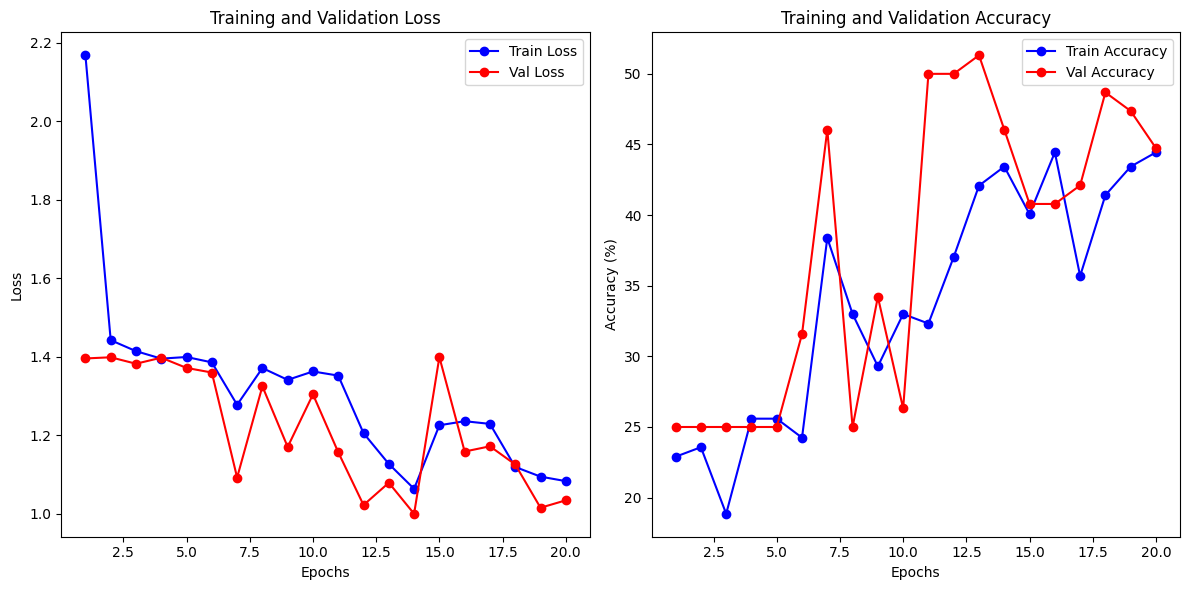

In [18]:
# Plotando os gráficos
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses6, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses6, label='Val Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies6, label='Train Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies6, label='Val Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

A partir da aplicação desse modelo VGG ao dataset com aumento de dados foi possível tirar as seguintes conclusões, com base nesse treinamento e na comparação com o treinamento anterior.

Este modelo apresentou um aprendizado mais eficaz que o anterior, com melhorias na acurácia de treinamento e validação. A acurácia de validação melhorou de 25% para 51,32%, e a perda de validação diminuiu. A perda de treinamento também diminuiu, indicando que o modelo está ajustando melhor seus parâmetros.

Portanto, este modelo é claramente superior ao modelo anterior, pois a acurácia de validação é 51,32%, comparado com 25% do primeiro modelo; melhor desempenho de treinamento, pois tem um aumento constante na acurácia de treinamento, enquanto o modelo anterior tem dificuldade em melhorar; e  tem uma perda de validação mais baixa, o que indica melhor generalização. Entretanto, também há bastante oscilação.

Enfim, este modelo está mostrando um desempenho mais estável e promissor, enquanto o modelo anterior apresentava dificuldades em aprender de forma eficaz, o que indicava estado de overfitting ou underfitting, sem evolução significativa.






# **8. Congelamento das Camadas**

In [10]:
# Carregar ResNet50 com pesos pré-treinados
resnet_model_v1 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in resnet_model_v1.parameters():
    param.requires_grad = False

# Modificar a camada final para o número de classes do dataset
num_classes = len(train_set_aug.classes)

resnet_model_v1.fc = nn.Linear(resnet_model_v1.fc.in_features, num_classes)

# Transferir os modelos para o dispositivo (GPU ou CPU)
resnet_model_v1 = resnet_model_v1.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_resnet_v1 = optim.Adam(resnet_model_v1.parameters(), lr=0.001)

In [11]:
# Listas para armazenar as métricas de cada época
train_losses0 = []
train_accuracies0 = []
val_losses0 = []
val_accuracies0 = []

num_epochs = 20

# Treinamento e Avaliação do ResNet50 (versão 1)
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(resnet_model_v1, train_loader_aug, criterion, optimizer_resnet_v1, device)
    val_loss, val_acc = evaluate(resnet_model_v1, val_loader, criterion, device)

    # Armazenar os resultados
    train_losses0.append(train_loss)
    train_accuracies0.append(train_acc)
    val_losses0.append(val_loss)
    val_accuracies0.append(val_acc)

    # Exibir os resultados
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/20
Train Loss: 1.3615, Train Accuracy: 34.34%
Val Loss: 1.1496, Val Accuracy: 44.74%
Epoch 2/20
Train Loss: 1.1032, Train Accuracy: 55.22%
Val Loss: 0.7893, Val Accuracy: 77.63%
Epoch 3/20
Train Loss: 0.8637, Train Accuracy: 72.39%
Val Loss: 0.6332, Val Accuracy: 81.58%
Epoch 4/20
Train Loss: 0.7451, Train Accuracy: 75.76%
Val Loss: 0.5052, Val Accuracy: 92.11%
Epoch 5/20
Train Loss: 0.6663, Train Accuracy: 78.45%
Val Loss: 0.4937, Val Accuracy: 88.16%
Epoch 6/20
Train Loss: 0.6704, Train Accuracy: 76.09%
Val Loss: 0.3887, Val Accuracy: 90.79%
Epoch 7/20
Train Loss: 0.5496, Train Accuracy: 82.49%
Val Loss: 0.2989, Val Accuracy: 92.11%
Epoch 8/20
Train Loss: 0.6056, Train Accuracy: 80.47%
Val Loss: 0.3179, Val Accuracy: 89.47%
Epoch 9/20
Train Loss: 0.5409, Train Accuracy: 82.83%
Val Loss: 0.2599, Val Accuracy: 93.42%
Epoch 10/20
Train Loss: 0.5248, Train Accuracy: 81.48%
Val Loss: 0.2468, Val Accuracy: 90.79%
Epoch 11/20
Train Loss: 0.4892, Train Accuracy: 84.85%
Val Loss: 0.26

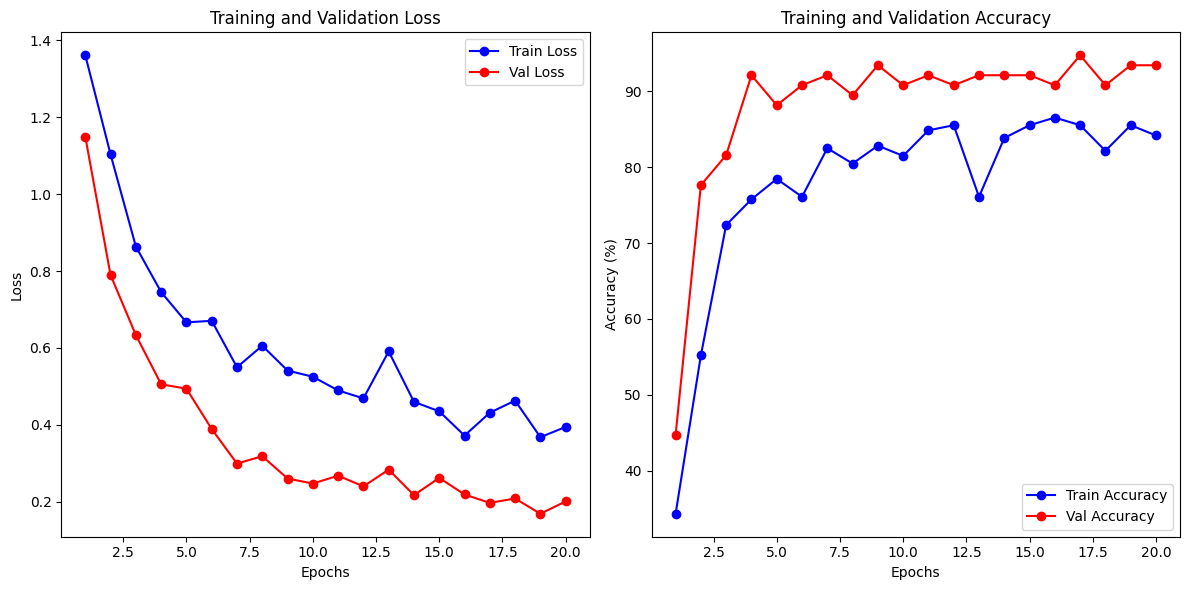

In [12]:
# Plotando os gráficos
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses0, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses0, label='Val Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies0, label='Train Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies0, label='Val Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

A partir da aplicação desse modelo ResNet50 (versão 1) ao dataset com aumento de dados, e congelamento de camada, foi possível tirar as seguintes conclusões, principalmente quando comparado com a primeira versão que não teve congelamento de camadas.

Ambos os modelos terminam com boas performances, com uma acurácia de validação alta (92.11% para o primeiro modelo e 94.74% para o segundo) e uma perda de validação baixa (0.2614 para o primeiro e 0.1681 para o segundo- ambos época 19).

O segundo modelo apresentou uma melhoria significativa na acurácia de treinamento ( 86.53% na época 16), na acurácia de validação (94.74% na época 17), assim como uma perda de treinamento menor no final (0.3674 na época 19) e  perda de validação mais baixa (0.1681 na época 19).

Enfim, o segundo modelo, com congelamento de camadas, mostrou uma performance mais consistente e uma taxa de melhora mais rápida, com uma maior acurácia final tanto de treinamento quanto de validação. A perda de validação também é menor, sugerindo que ele pode ser mais eficiente em generalizar para dados não vistos. O primeiro modelo, sem congelamento de camadas, embora tenha alcançado uma boa acurácia, demonstrou mais volatilidade durante o treinamento, com picos e quedas na acurácia de validação. Ele ainda é competitivo, mas a performance do segundo modelo foi mais estável e confiável. Portanto, o congelamento das camadas melhorou a performance do modelo.





# **9. Conclusões**

A coleta de dados, mesmo que simples, é de grande importância para o desenvolvimento de modelos de CNN de classificação, independente se pré-treinados ou não. É importante ter atenção na representatividade desses dados, tanto no âmbito da qualidade como quantidade.

Os dados coletados foram poucos, mas através do processo de data augmentation ocorreu a melhoria da quantidade de dados e também a melhora de performance em alguns modelos pré-treinados como REsNet50 (versão 1 e 2) e VGG.

Também é importante ressaltar que o modelo ResNet50 (versão 1) foi o que teve melhor performance, principalmente na acúracia e perda de validação. Éssa performance foi melhor apenas quando aplicado a base de dados que teve aumento de dados, através do data augmentation.

Alguns modelos apresentaram possíveis overfitting, dificuldades de generalização para a base de validação, bem como oscilações.Entretanto, esses foram os melhores resultados encontrados após diversos treinamentos realizados e mudanças em critérios como otimizadores, camadas, números de épocas, learning rate e outros.

Ademais, devido o limite de tempo de pesquisa e treinamento, algumas conclusões foram tecidas ao longo do trabalho a fim de que na possibilidade de continuação de novos treinamentos, novas técnicas sejam aplicadas. As possíveis novas técnicas variam de acordo com o problema, mas em geral foram sugeridas a aplicação de regularização (novas camadas de dropout ou L2 regularization), ajustar novas taxas de aprendizado, experimentar redução gradual da taxa de aprendizado (learning rate scheduler) e early stopping.

Sobre o congelamento das camadas, apenas foi aplicado no Resnet50, versão 1, base de dados com data augmentation, uma vez que havia o objetivo de melhorar a performance de um modelo já considerado bom.